### <p style="text-align: right;"> &#9989; Andrew Koren.</p>

# PHY480 Homework 2


This homework contains exercises on the following topics:

- numerical integration,
- solving a system of ordinary differential equations with a Runge-Kutta method,
- solving a system of ordinary differential equations with the leapfrog method.

The physical examples are electrostatic problems, Lorenz attractor and projectile motion.

**There are 12 problems with the total of 74 points.**

**The deadline for the homework is Friday, Feb. 21, 2025, 6:00 pm.**


In [280]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import scipy

## Numerical integration

### Uniformly charged rod

Consider the following problem in two dimensions. There is an infinitely thin rod that is positioned parallel to the $x$-axis, occupying the region in $x$ from $-d$ to $d$ (i.e. the length of the rod is $2d$) and possibly displaced from the origin in the $y$ direction by $y_0$. It is uniformly charged to have total charge $Q$. This means the linear charge density is $Q/(2d)$. Consider an arbitrary point $\vec{r}=(x,y)$ somewhere outside the rod. The task is to find the electric potential and the electric field at that point $\vec{r}$.

The electric potential is given in general as an integral over the charge density:

$$
\phi(\vec{r})=\frac{1}{4\pi\varepsilon_0}\int_{\text{charged region}}\frac{\rho(\vec{r}')d\vec{r}'}{|\vec{r}-\vec{r}'|}.
$$

The prefactor $1/(4\pi\varepsilon_0)$ can be eleminated by redifinition of the charge, i.e., $Q/(4\pi\varepsilon_0)\to Q$, so it can be dropped for convenience. The charge density is $Q/(2d)$ and the charged region is the linear region occupied by the rod. Thus, the potential at $\vec{r}=(x,y)$ is given by

$$
\phi(\vec{r})=\frac{Q}{2d}\int_{-d}^{d}\frac{dx'}{\sqrt{(x-x')^2+(y-y_0)^2}}.
$$

This is a one-dimensional integral on $x'$, the $Q$, $d$ and $y_0$ are constants and $(x,y)$ is the point at which we evaluate the potential. Thus, $x$, $y$ are also some arbitrary constants as far as the integral is concerned.


**Problem 1 (8 points).** Fill in the integration function that uses Simpson's rule, modify it to accept an arbitrary number of additional parameters `*args` (those will be passed to the function to be integrated `fun`).


In [281]:
# numerical integration with Simpson's rule
# Input:
# fun -- function to be integrated, callable
# a, b -- range
# N -- number of subintervals for integration, has to be odd, step size h=(b-a)/(N-1)
# *args -- list of arguments
# Output:
# definite integral, scalar

def integrate_simpson( fun, a, b, N, *args):
    if N % 2 == 1:
        N -= 1 # makes steps but that's okay

    h = (b-a)/N
    s = fun(a, *args) + fun(b, *args)

    for k in range(1,N,2):
        s += 4*fun(a+k*h, *args)
    for k in range(2, N-1,2):
        s += 2*fun(a+k*h, *args)
    
    return s*h/3

**Problem 2 (4 points).** Set up the proper function to be integrated and write a function that, given a two-dimensional position vector $\vec{r}$ (and constants $Q$, $d$, $y_0$), returns the potential at the point $\vec{r}$. Internally it should call the Simpson's rule function.

To help you debug these functions, the results from the exact closed-form solution of the charged rod problem are given below.

For `electric_pot_rod_simpson( [2.,2.], 3, 1.5, -1 )` call you expect the result to be close to `0.8285529435484651`.

For `electric_pot_rod_simpson( [1.5,0.8], -1.2, 0.9, 0.5 )` call you expect the result to be close to `-0.8885578703632715`.

In [282]:
# integrand for the charged rod problem
# Input:
# xp -- scalar, point at which the integrand is evaluated (i.e. within the rod region)
# r -- array of two values: x,y -- the point at which we are evaluating the potential
# Q, d, y0 -- constants
# Output:
# scalar, the integrand for the charged rod problem
def integrand_charged_rod( xp, r, Q=1, d=1, y0=0 ):

    # unpack x,y
    x = r[0]
    y = r[1]
    
    return Q/(2*d) * 1/(np.sqrt((x-xp)**2 + (y-y0)**2))

# electric potential from charged rod at a given point
# Input:
# r -- array of two values: x,y -- the point at which we are evaluating the potential
# Q, d, y0 -- constants
# Output:
# scalar, electric potential at the point (x,y)
def electric_pot_rod_simpson( r, Q=1, d=1, y0=0 ):
    
    N = 301 # number of points for Simpson's rule

    phi = integrate_simpson(integrand_charged_rod, -d, d, N, r, Q, d, y0)

    return phi

In [283]:
print(electric_pot_rod_simpson([2,2], 3, 1.5, -1))
print(electric_pot_rod_simpson( [1.5,0.8], -1.2, 0.9, 0.5 ))

0.8285529435475812
-0.8885578704260747


To get more accurate results for the two inputs:

**Problem 3 (4 points).** The electric field is given by the negative gradient of the potential:

$$
\vec{E}(\vec{r})=-\vec\nabla \phi(\vec{r}).
$$

Write a function that uses the central finite difference to calculate the gradient of the potential and returns the electric field. Call the electric potential function `electric_pot_simpson` you produced in Problem 2.

To help you debug the function, the results from the exact closed-form solution of the charged rod problem are given below.

For `electric_field_rod_finite_diff( [2.,2.], 3, 1.5, -1 )` call you expect the result to be close to `[0.11186752 0.19828587]`.

For `electric_field_rod_finite_diff( [1.5,0.8], -1.2, 0.9, 0.5 )` call you expect the result to be close to `[-0.71817525 -0.21744597]`.

In [284]:
# central finite difference
# Input:
# fun -- function to be derived (scalar output)
# x -- at which point
# dim -- input number to vary
# eps -- step size for approximations
def df_central( fun, x, dim=None, eps=0.001, *args): 

    if dim==None:
        return (fun(x+eps/2, *args) - fun(x-eps/2, *args))/2

    x = list(x)
    x[dim] += eps/2 # i'm sure messing with x won't cause any problems
    f1 = fun(x, *args)
    x[dim] -= eps
    f2 = fun(x, *args)
    x[dim] += eps/2 # just in case
    return (f1 - f2)/eps

def grad( fun, r, eps=0.001 , *args):
    grad = []
    for dim in range(len(r)):
        partial = df_central(fun, r, dim, eps, *args)
        grad.append(partial)
    return np.array(grad)

In [285]:
# electric field from charged rod at a given point
# Input:
# r -- array of two values: x,y -- the point at which we are evaluating the electric field
# Q, d, y0 -- constants
# Output:
# array of two values -- the electric field at the point (x,y)
def electric_field_rod_finite_diff( r, Q=1, d=1, y0=0 ):
    
    # the field diverges close to the rod, therefore return 0
    # if r=(x,y) is too close
    if np.abs( r[0] ) < d*1.05 and np.abs( r[1] - y0 ) < 0.05:
        return np.zeros(2)

    # step for the central finite difference, may be adjusted
    h = 1e-5
    
    E = -grad(electric_pot_rod_simpson, r, h, Q, d, y0)
    
    return E

electric_field_rod_finite_diff([2.,2.], 3, 1.5, -1 )

array([0.11186752, 0.19828587])

**Problem 4 (6 points).** Consider a positively charged rod with parameters $Q=1$, $d=1$, $y_0=0$. Plot the electric field from the charged rod on a grid as arrows whose lengths are proportional to the electric field (you can use, for instance `plt.arrow`). As the electric field can vary depending on the parameters, write the code in such a way that you can rescale all arrow lengths with a parameter, so that you can adjust the lengths and the arrows are not too large or too small. An example plot with the constants given above is shown below. The arrow lengths are rescaled.

![minimization](hw02_elfield1.png)


To plot the charged rod itself you can use, for instance:

```
plt.fill( [-d,-d,d,d], [y0-0.04,y0+0.04,y0+0.04,y0-0.04] )
```

Experiment with setting $d=0.1$, $0.5$, $1.5$, $2$, $5$ and changing $y_0$ in the range from $-2$ to $2$. See, if making the rod shorter or longer matches your intuition about what field pattern it should produce.

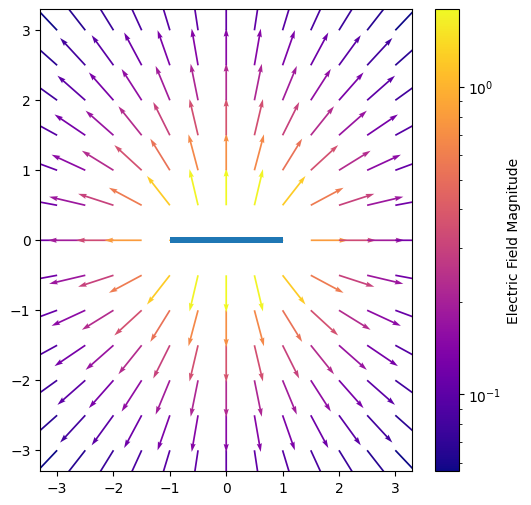

In [286]:
# the grid of points on x and y
a = 3 # x-range [-a,a]
b = 3 # y-range [-b,b]
nx = 13 # how many points on x
ny = 13 # how many points on y

# parameters of the rod are automatically inputted
Q = 1
d = 1
y0 = 0

X = np.linspace(-a, a, nx)
Y = np.linspace(-b, b, ny)

x, y = np.meshgrid(X, Y)
R = np.column_stack((x.ravel(), y.ravel()))
dR = np.array([electric_field_rod_finite_diff(r) for r in R])

mag = np.sqrt(dR[:,0]**2+dR[:,1]**2)
mag[mag==0] = 1
dR_norm = dR/np.column_stack((mag, mag))

plt.figure(figsize=(6,6))
Efield = plt.quiver(R[:,0], R[:,1], dR_norm[:,0], dR_norm[:,1], mag, scale=10, norm=LogNorm(), cmap='plasma')
plt.fill( [-d,-d,d,d], [y0-0.04,y0+0.04,y0+0.04,y0-0.04] )

cbar = plt.colorbar(Efield)
cbar.set_label("Electric Field Magnitude")

**Problem 5 (6 points).** Repeat the previous problem for two charged rods: $Q=1$, $d=1$, $y_0=1$ and $Q=-1$, $d=1$, $y_0=-1$. Experiment with changing $d$ (or even making the lengths different). See if changing $d$ matches your intuition of what field pattern you expect for this system.

**Note:** Recall that due to the superposition principle, the field of several charged objects is simply a vector sum of the fields from each one.

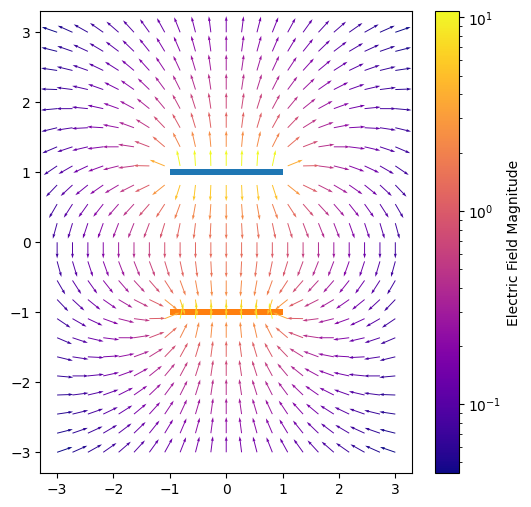

In [287]:
# the grid of points on x and y
a = 3 # x-range [-a,a]
b = 3 # y-range [-b,b]
nx = 23 # how many points on x
ny = 23 # how many points on y


X = np.linspace(-a, a, nx)
Y = np.linspace(-b, b, ny)

x, y = np.meshgrid(X, Y)
R = np.column_stack((x.ravel(), y.ravel())) # list of all points in grid
dR = np.zeros_like(R) # store electric field here

plt.figure(figsize=(6,6))

params_list = [[1, 1, 1], [-1, 1, -1]]
for params in params_list:
    Q, d, y0 = params
    dR += np.array([electric_field_rod_finite_diff(r, Q, d, y0) for r in R])
    plt.fill( [-d,-d,d,d], [y0-0.04,y0+0.04,y0+0.04,y0-0.04] )


mag = np.sqrt(dR[:,0]**2+dR[:,1]**2)
mag[mag==0] = 0.0001
dR_norm = dR/np.column_stack((mag, mag))

Efield = plt.quiver(R[:,0], R[:,1], dR_norm[:,0], dR_norm[:,1], mag, scale=(nx+ny)/2, norm=LogNorm(), cmap='plasma')

cbar = plt.colorbar(Efield)
cbar.set_label("Electric Field Magnitude")

### Uniformly charged rectangle

Consider now a charged rectangle with the total charge $Q$ occuping the region of space $[-l_x,l_x]\cup[-l_y,l_y]$. The charge density is now $Q/(4l_xl_y)$. The potential at the point $\vec{r}=(x,y)$ from such an object is now given by a two dimensional integral, since the charge occupies a two-dimensional region:

$$
\phi(\vec{r})=\frac{Q}{4l_xl_y}\int_{-l_x}^{l_x}dx'\int_{-l_y}^{l_y}dy'\,
\frac{1}{\sqrt{ (x-x')^2+(y-y')^2 }}.
$$


**Problem 6 (5 points).** For the charged rectangle problem we are going to use the `scipy.integrate.dblquad` function for integration of double integrals. Study the SciPy documentation to understand how to properly set up the function that returns the integrand. Most importantly, the first two arguments are $y'$ and $x'$, i.e., the current integration point, in that order. The rest are the parameters for the integrand. 

Complete the function that returns the integrand and use it to compute the potential from the charged rectangle using `scipy.integrate.dblquad`.

**NOTE:** Be careful with the return value of `scipy.integrate.dblquad`. It may return a complex number, so be sure to take only the real part.

In [288]:
# integrand for the charged rectangle problem
# Input:
# yp, xp -- point (x',y') at which the integrand is evaluated (i.e. within the square region),
#           NOTE THE OPPOSITE ORDER AND THAT yp AND xp ARE PASSED AS SCALARS, NOT A 2D ARRAY
# r -- array of two values: x,y -- the point at which we are evaluating the potential
# Q, lx, ly -- constants
# Output:
# scalar, the integrand for the charged rectangle problem
def integrand_charged_rectangle( yp, xp, r, Q=1, lx=1, ly=1 ):
    
    # unpack
    x = r[0]
    y = r[1]
    const = Q / ( 4 * lx * ly )
    
    return const * 1/((x-xp)**2 + (y-yp)**2) 

# electric potential from charged rectangle at a given point
# Input:
# r -- array of two values: x,y -- the point at which we are evaluating the potential
# Q, lx, ly -- constants
# Output:
# scalar, electric potential at the point (x,y)
def electric_pot_rec_dblquad( r, Q=1, lx=1, ly=1 ):
    
    params = [r, Q, lx, ly]
    if abs(r[0]) <= lx and abs(r[1]) <= ly:
        return np.array([0,0])

    return scipy.integrate.dblquad(integrand_charged_rectangle, -lx, lx, -ly, ly, args=params)[0]

**Problem 7 (4 points).** As before, the electric field is given by the negative gradient of the potential:

$$
\vec{E}(\vec{r})=-\vec\nabla \phi(\vec{r}).
$$

Write a function that uses the central finite difference to calculate the gradient of the potential and return the electric field. Call `electric_pot_rec_dblquad` to evaluate the potential.



In [289]:
from scipy.integrate import dblquad

# electric field from charged rectangle at a given point
# Input:
# r -- array of two values: x,y -- the point at which we are evaluating the electric field
# Q, lx, ly -- constants
# Output:
# array of two values -- the electric field at the point (x,y)
def electric_field_rec_finite_diff( r, Q=1, lx=1, ly=1 ):
    
    # the field diverges close to the rectangle, therefore return 0
    # if r=(x,y) is too close
    if np.abs( r[0] ) < lx*1.05 and np.abs( r[1] )<ly*1.05:
        return np.zeros(2)

    # step for the central finite difference, may be adjusted
    h = 1e-5

    E = -grad(electric_pot_rec_dblquad, r, h, Q, lx, ly)

    return E

**Problem 8 (6 points).** Plot the electric field from the charged rectangle with parameters $Q=1$, $l_x=1.5$, and $l_y=1$. Experiment with changing the sizes and think how you can check the correctness of your code by making this problem similar to the problem with a charged rod considered previously.

The result is expected to be similar to the figure below.

![minimization](hw02_elfield2.png)



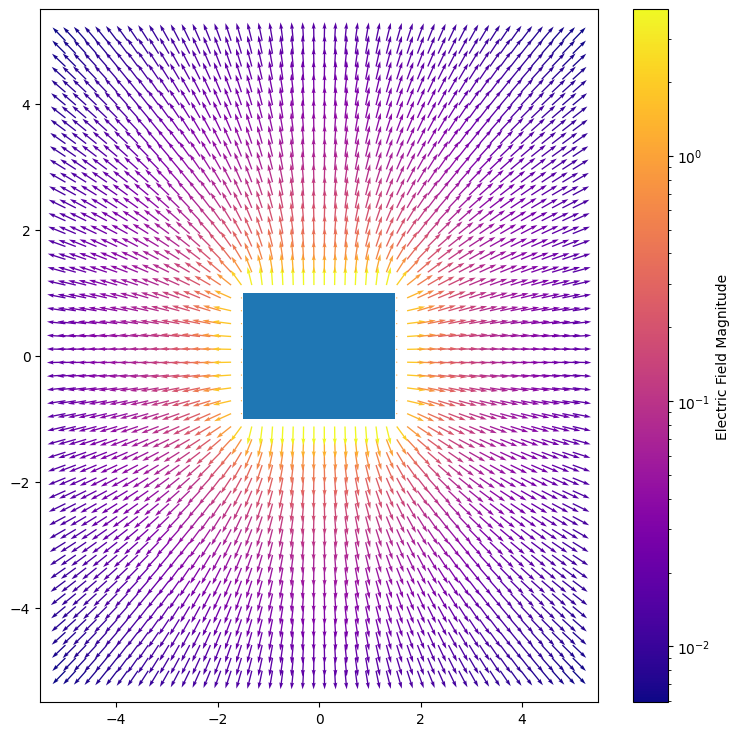

In [290]:
# the grid of points on x and y
a = 5 # x-range [-a,a]
b = 5 # y-range [-b,b]
nx = 50 # how many points on x
ny = 50 # how many points on y

# parameters of the rectangle
Q = 1
lx = 1.5
ly = 1

# YOUR CODE HERE
X = np.linspace(-a, a, nx)
Y = np.linspace(-b, b, ny)

x, y = np.meshgrid(X, Y)
R = np.column_stack((x.ravel(), y.ravel()))
dR = np.array([electric_field_rec_finite_diff(r, Q, lx, ly) for r in R])

mag = np.sqrt(dR[:,0]**2+dR[:,1]**2)
mag[mag==0] = 1
dR_norm = dR/np.column_stack((mag, mag))

plt.figure(figsize=(9,9))
Efield = plt.quiver(R[:,0], R[:,1], dR_norm[:,0], dR_norm[:,1], mag, scale=30, norm=LogNorm(), cmap='plasma')
plt.fill( [-lx,-lx,lx,lx], [-ly, ly, ly, -ly] )

cbar = plt.colorbar(Efield)
cbar.set_label("Electric Field Magnitude")

## Numerical integration of ordinary differential equations: Lorenz attractor

Consider the following system of equations:

$$
\frac{dx}{dt}=-\alpha(x-y),
$$

$$
\frac{dy}{dt}=(\delta+1)x - y - xz,
$$

$$
\frac{dz}{dt}=-\beta z + xy.
$$

We consider $\alpha,\beta>0$. This system exhibits chaotic behavior and is known as the _Lorenz attractor_. It is described in various textbooks, the form used here follows Landau, Paez, Bordeianu.

The system possesses several fixed points depending on the parameters $\alpha$, $\beta$ and $\delta$.


**Problem 9 (10 points).** Code the Runge-Kutta solver that can accept an arbitrary number of stages $s$ and Butcher tableu (coefficients $a_{ij}$, $b_i$ and $c_i$).


In [291]:
# Runge-Kutta integrator with a specified Butcher tableau
# Input:
# rhs -- the right-hand-side function f(x,y)
# y0 -- the initial value y(x0)=y0, it must be a NumPy array or a list
#       (even in the scalar case it must be defined as array or list with one element)
# x0 -- initial integration point on x
# xf -- final integration point on x (i.e. we are finding y(x) in [x0,xf] range)
# h -- step size
# s -- number of Runge-Kutta stages
# a,b,c -- Butcher tableau
# args -- additional arguments (e.g. parameters) for f(x,y)
# Output:
# status -- =0 on success
# y -- the last point y(xf)
# xlist -- list of all x points during the integration
# ylist -- y(x) at the x points above
def integrate_ode_rungekutta( rhs, y0:np.array, x0, xf, h, s, a, b, c, args=None):

    # set the dimension of the y vector
    nd = len(y0)
    
    # k_i storage
    kf = np.zeros( (s,nd) )
    
    # number of steps, may need one more if xf-x0 is not
    # an integer multiple of h
    nf = ( xf - x0 ) / h
    n = int(nf)

    # initialization
    xlist = [x0]
    ylist = [y0]
    status = 1
    
    y = y0.copy()

    # integration
    for step in range(n+1): #integration steps
        if step == n:
            if xlist[-1] == xf: # last step verification
                break
            else:
                h = xf - xlist[-1]

        for i in range(s): #rk steps
            yi = y + h * sum(a[i,j] * kf[j] for j in range(i)) 
            ki = rhs(xlist[-1]+h*c[i], yi, *args)
            y += h * b[i] * ki
        xlist.append(xlist[-1]+h)
        ylist.append(y.copy())

    if xlist[-1] == xf:
        status = 0   
    
    return status, y, xlist, ylist


In [292]:
# common fourth-order Runge-Kutta method
s = 4
a = np.zeros( (s,s) )
b = np.zeros( s )
c = np.zeros( s )

a[1,0] = 1/2
a[2,1] = 1/2
a[3,2] = 1
b[0] = 1/6
b[1] = 1/3
b[2] = 1/3
b[3] = 1/6
c[1] = 1/2
c[2] = 1/2
c[3] = 1

print(a,b,c)

[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]] [0.16666667 0.33333333 0.33333333 0.16666667] [0.  0.5 0.5 1. ]


**Problem 10 (5 points).** Complete the right-hand-side function for the Lorenz attractor and integrate the trajectory up to different final times $t_f=10, 20, 30, 40, 50$. Plot the results for $t_f=50$ on a three-dimensional plot. (Consult the literature on how the expected plot should looks like.)

In [293]:
# right-hand-side function for the Lorenz attractor
# t -- time
# rvec -- three-dimensional vector of current (x,y,z)
# alpha, beta, delta -- parameters
def rhs_lorenz( t, rvec, alpha=10, beta=8/3, delta=24):
    
    # unpack
    x = rvec[0]
    y = rvec[1]
    z = rvec[2]

    dx = -alpha*(x-y)
    dy = (delta+1)*x-y-x*z
    dz = -beta*z+x*y

    return np.array([dx, dy, dz])


In [294]:
# example parameters
alpha = 10
beta = 8/3
delta = 24

# integrate from 0 to tf, experiment with tf=10,20,30,40,50
t0 = 0.
tf = 50.

# the initial condition x=1, y=0, z=0
r0 = np.array( [ 1., 0., 0. ] )

# step size
h = 0.01

# YOUR CODE HERE
params = [alpha, beta, delta]
status, y, xlist, ylist = integrate_ode_rungekutta(rhs_lorenz, r0, t0, tf, h, s, a, b, c, params)

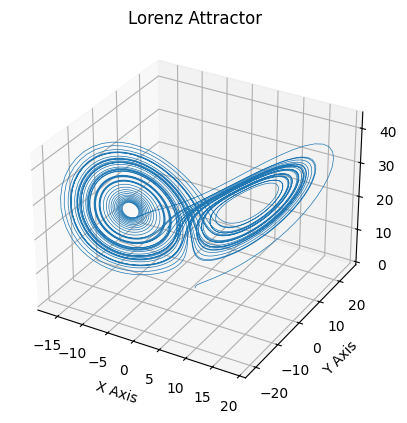

In [295]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*np.array(ylist).T, lw=0.5)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Lorenz Attractor')

plt.show()

## Numerical integration of ordinary differential equations: projectile motion without friction

Consider two-dimensional projectile motion described by the equation

$$
m\frac{d^2\vec{r}}{dt^2}=\vec{F}=m\vec{g},
$$
where $\vec{g}$ is the acceleration due to gravity.

With the usual choice of the coordinate system and rewriting separately the position and momenta (velocity) equations we have:

$$
\frac{d}{dt}q\equiv \frac{d}{dt}
\left(
\begin{array}{r}
x \\
y
\end{array}
\right)
=
\left(
\begin{array}{r}
p_x \\
p_y
\end{array}
\right)
\equiv p,
$$

$$
\frac{d}{dt}p\equiv \frac{d}{dt}
\left(
\begin{array}{r}
p_x \\
p_y
\end{array}
\right)
=
\left(
\begin{array}{r}
0 \\
-g
\end{array}
\right)
\equiv f(q).
$$

In this case the force $f(q)$ is independent of $q$.

The initial condition is

$$
\vec{q}_0=
\left(
\begin{array}{r}
0 \\
0
\end{array}
\right),\,\,\,\,\,
\vec{p}_0=
\left(
\begin{array}{r}
v_0\cos(\theta) \\
v_0\sin(\theta)
\end{array}
\right).
$$



**Problem 11 (10 points).** Code the leapfrog integrator.

In [296]:
def leap(q, p, f, h):
    '''
    Time evolves by h

    Args:
        q: start position q(t)
        p: start momentum p(t-h/2)
        f: forces (pre-calculated)
        h: step size
    Returns: q(t+h), p(t+h/2)
    '''
    ph = p + h*f
    qh = q + h*ph
    return qh, ph



# integrate Hamilton's equations dq/dt = p and dp/dt=f(q) with a leapfrog scheme
# Input:
# forces -- a function that returns f(q), as an array of the same dimension as q and p
# q0 -- the initial value of the position, it must be a NumPy array or a list
#       (even in the scalar case it must be defined as array or list with one element)
# p0 -- the initial value of the momentum, it must be a NumPy array or a list
#       (even in the scalar case it must be defined as array or list with one element)
# t0 -- initial time
# nsteps -- number of steps
# h -- step size
# *args -- additional arguments (e.g. parameters) for f(q)
# Output:
# status -- =0 on success
# q, p -- the position and momenta at the end of the trajectory q(t0+nsteps*h), p(t0+nsteps*h)
# tlist -- list of all time points during the integration
# qlist -- list of all positions during the trajectory, of size nsteps+1
# plist -- list of all momenta during the trajectory, of size nsteps+2 (!)
def integrate_ode_leapfrog( forces, q0, p0, t0, nsteps, h, *args ):
    
    # initialization
    tlist = [ t0 ]
    status = 1

    # unpack position and momentum explicitly
    q = q0.copy()
    p = p0.copy()
    
    qlist = [ q.copy() ]
    plist = [ p.copy() ]

    # first half step for momentum
    if args==None:
        f = forces( t0, q )
    else:
        f = forces( t0, q, *args )
    p += h/2*f
    plist.append( p.copy() )

    # YOUR CODE HERE
    for n in range(nsteps):
        t = t0 + n*h
        f = forces(t, qlist[-1], *args) if args else forces(t, qlist[-1])
        qh, ph = leap(qlist[-1], plist[-1], f, h)
        tlist.append(t+h)
        qlist.append(qh)
        plist.append(ph)

    # only have p(t+h/2), still need p(t) 
    pf = (plist[-1]+plist[-2])/2

    status = 0

    return status, qlist[-1], pf, tlist, qlist, plist

**Problem 12 (6 points).** Code the right-hand-side function with the signature shown below. Use it to solve the following problem. Given the initial starting point at the ground level $(0,0)$, the initial velocity $v_0=100$ m/s and the initial angle $\theta$ (to be adjusted) integrate the equations of motion with the leapfrog method, until the object hits the ground (i.e. $y(t)=0$). (You can integrate until some time $t_f$ and then discard the part of the trajectory for which $y(t)<0$.) Start with values of the initial angle $\theta$ in the range $[40,50]$ degrees to see how far on $x$ the project can land.
Then try adjusting the initial angle (perhaps, below 40 degrees) until the object lands in the interval on $x$ $[790,810]$. (I.e. find an aiming angle at which the object hits the ground at $800\pm10$ meters.) 

You need to adjust the number of steps for integration `nsteps` and the final time `tf` so that the integration is stable and it covers full trajectory until the object lands.

Plot the resulting trajectory.

In [297]:
# force for two-dimensional projectile motion (no drag)
# Input:
# t -- time
# q -- two-dimensional position vector
# g -- parameter, the acceleration due to gravity
def forces_projectile( t, q, g=9.8 ):
    
    # unpack
    x = q[0]
    y = q[1]
    
    return np.array([0, -g])


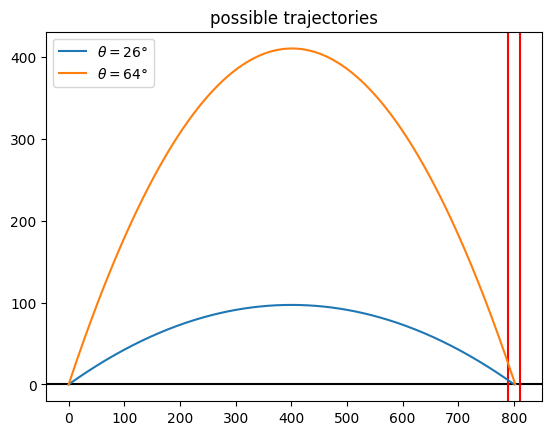

In [298]:
# constants
v0 = 100
g = 9.8
theta = 26/360*2*np.pi # could use gradient descent, but guessing is quick enough

# the initial conditions
q0 = np.array( [0.,0.] )
p0 = np.array( [v0*np.cos(theta),v0*np.sin(theta)] )

# start and finish time
t0 = 0
tf = 20 #set the final time

# number of steps and step size
nsteps = 1000 #set the number of steps
h = tf/nsteps # set the step size

# solve with the leapfrog
status, q, p, tlist, qlist, plist = integrate_ode_leapfrog( forces_projectile, q0, p0, t0, nsteps, h )

theta2 = 64/360*2*np.pi
p0 = np.array( [v0*np.cos(theta2),v0*np.sin(theta2)] )
_, _, _, _, second_angle, _ = integrate_ode_leapfrog( forces_projectile, q0, p0, t0, nsteps, h )
second_angle = np.array(second_angle)


# make sure the trajectory ends at the ground level
q_array = np.array(qlist)
valid_values = q_array[q_array[:,1] >=0]

# plot the resulting trajectory
plt.title('possible trajectories')
plt.axhline(0, color='black')
plt.axvline(790, -10, 10, color='red')
plt.axvline(810, -10, 10, color='red')
plt.plot(valid_values[:, 0], valid_values[:, 1], label=rf'$\theta={theta*180/np.pi:.0f}\degree$')
plt.plot(*second_angle[second_angle[:,1] >=0].T, label=rf'$\theta={theta2*180/np.pi:.0f}\degree$')
plt.legend()

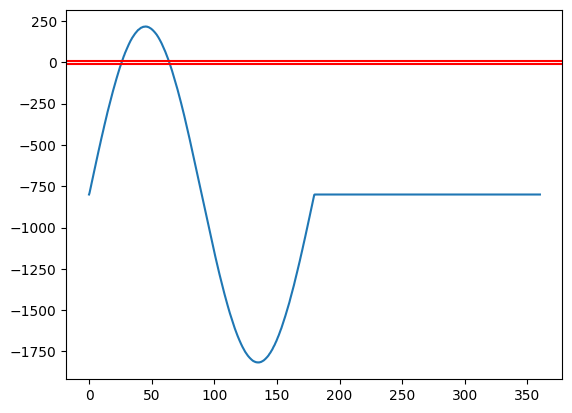

In [299]:
theta_space = np.linspace(0, 2*np.pi, 1000)
p0_vals = np.array( [v0*np.cos(theta_space),v0*np.sin(theta_space)] )

xf = []
target_pos = 800

for p0 in p0_vals.T:
    status, q, p, tlist, qlist, plist = integrate_ode_leapfrog( forces_projectile, q0, p0, t0, nsteps, h )
    q_array = np.array(qlist)
    valid_values = q_array[q_array[:,1] >=0]
    xf.append(valid_values[-1, 0]-target_pos)

plt.plot(theta_space*180/np.pi, xf)
plt.axhline(-10, color='red')
plt.axhline(10, color='red')

result = np.stack((theta_space*180/np.pi, xf))

In [302]:
print('Acceptable angles (deg):', *[format(x, '.2f') for x in result.T[abs(result[1]) < 10][:,0]])

Acceptable angles (deg): 25.59 25.95 26.31 63.78 64.14 64.50


&#169; Copyright 2025,  Michigan State University Board of Trustees

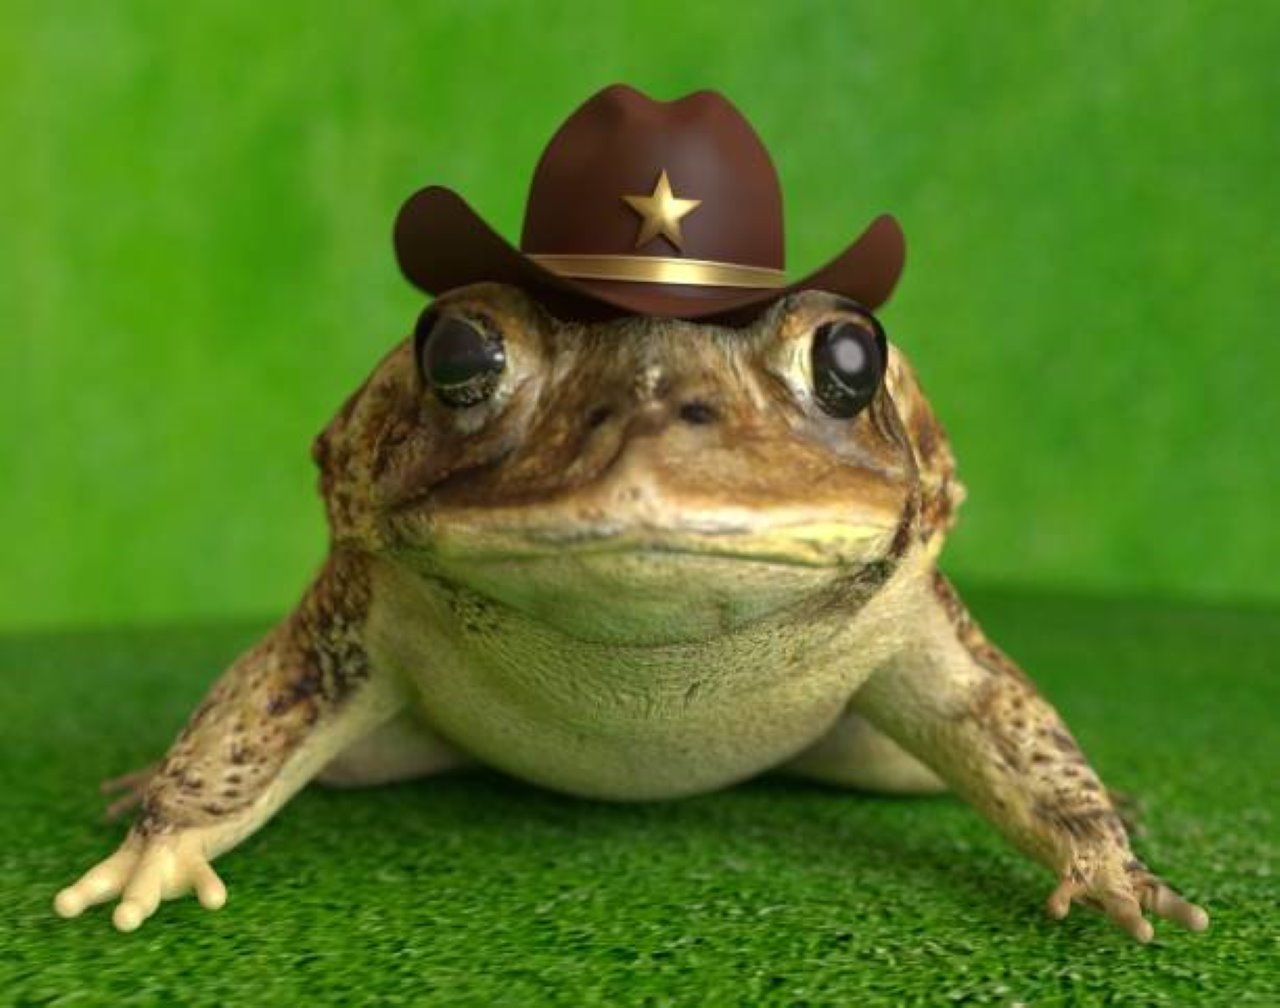